In [51]:
# import linecache
# from collections import Counter
# import os
# import tracemalloc
#
# def display_top(snapshot, key_type='lineno', limit=3):
#     snapshot = snapshot.filter_traces((
#         tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
#         tracemalloc.Filter(False, "<unknown>"),
#     ))
#     top_stats = snapshot.statistics(key_type)
#
#     print("Top %s lines" % limit)
#     for index, stat in enumerate(top_stats[:limit], 1):
#         frame = stat.traceback[0]
#         # replace "/path/to/module/file.py" with "module/file.py"
#         filename = os.sep.join(frame.filename.split(os.sep)[-2:])
#         print("#%s: %s:%s: %.1f KiB"
#               % (index, filename, frame.lineno, stat.size / 1024))
#         line = linecache.getline(frame.filename, frame.lineno).strip()
#         if line:
#             print('    %s' % line)
#
#     other = top_stats[limit:]
#     if other:
#         size = sum(stat.size for stat in other)
#         print("%s other: %.1f KiB" % (len(other), size / 1024))
#     total = sum(stat.size for stat in top_stats)
#     print("Total allocated size: %.1f KiB" % (total / 1024))

# tracemalloc.start()
# counts = Counter()
# experimentation(classification_dataset_names[0])
# snapshot = tracemalloc.take_snapshot()
# display_top(snapshot)

In [52]:
from ex_func import *
#from experiment_functions import *
import pandas as pd
from pmlb import fetch_data, classification_dataset_names
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
import pickle

In [53]:
classification_dataset_names

['GAMETES_Epistasis_2_Way_1000atts_0.4H_EDM_1_EDM_1_1',
 'GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1',
 'GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1',
 'GAMETES_Epistasis_3_Way_20atts_0.2H_EDM_1_1',
 'GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_50_EDM_2_001',
 'GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_75_EDM_2_001',
 'Hill_Valley_with_noise',
 'Hill_Valley_without_noise',
 'adult',
 'agaricus_lepiota',
 'allbp',
 'allhyper',
 'allhypo',
 'allrep',
 'analcatdata_aids',
 'analcatdata_asbestos',
 'analcatdata_authorship',
 'analcatdata_bankruptcy',
 'analcatdata_boxing1',
 'analcatdata_boxing2',
 'analcatdata_creditscore',
 'analcatdata_cyyoung8092',
 'analcatdata_cyyoung9302',
 'analcatdata_dmft',
 'analcatdata_fraud',
 'analcatdata_germangss',
 'analcatdata_happiness',
 'analcatdata_japansolvent',
 'analcatdata_lawsuit',
 'ann_thyroid',
 'appendicitis',
 'australian',
 'auto',
 'backache',
 'balance_scale',
 'biomed',
 'breast',
 'breast_cancer',
 'breast_cancer_wisconsin',
 'br

In [54]:
classification_dataset_names = ['breast_cancer_wisconsin','dermatology','diabetes']

In [55]:
def get_feature_type(x, include_binary=False):
    x.dropna(inplace=True)
    if not check_if_all_integers(x):
        return 'continuous'
    else:
        if x.nunique() > 10:
            return 'continuous'
        if include_binary:
            if x.nunique() == 2:
                return 'binary'
        return 'categorical'

def get_target_type(x, include_binary=False):
    x.dropna(inplace=True)
    if x.dtype=='float64':
        return 'continuous'
    elif x.dtype=='int64':
        if include_binary:
            if x.nunique() == 2:
                return 'binary'
        return 'categorical'
    else:
        raise ValueError("Error getting type")

def check_if_all_integers(x):
    "check a pandas.Series is made of all integers."
    return all(float(i).is_integer() for i in x.unique())
def corr_data_for(df):
    TARGET_NAME = 'target'
    feat_names = [col for col in df.columns if col!=TARGET_NAME]
    types = [get_feature_type(df[col], include_binary=True) for col in feat_names]
    col = pd.DataFrame(feat_names,types)
    num_col = col[col.index == 'continuous']
    bin_col = col[col.index == 'binary']
    cat_col = col[col.index == 'categorical']
    cat_col = cat_col[0].tolist()
    dummy_col = pd.get_dummies(data=df, columns=cat_col)
    add_col = dummy_col.shape[1] - df.shape[1]

    if (add_col < df.shape[0] *0.3) & (dummy_col.shape[1] <  df.shape[0]) & (df.shape[0] < 10000) & (df.shape[1] < 100):
        df = dummy_col
        df.columns = df.columns.str.replace('.','_',regex=True)
        y = df['target']
        X = df.loc[:, df.columns != 'target']
        del df
        rows_data, columns_data = X.shape
        print('Dataset Information')
        print('Rows:',rows_data,)
        print('Columns:',columns_data)
        print('Number of classes:',y.nunique())
        print('Continous columns:', len(num_col))
        print('Binary columns:', len(bin_col))
        print('Categorical columns:',len(cat_col))
        print('-------------------------------------------------')
    else:
        del df
        return pd.DataFrame, pd.DataFrame
    return y, X

In [56]:
def split_function(y,X,it):
    sc = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = it, stratify=y)
    X_col = X_train.columns
    X_test.name = "X_test"
    X_train.name = "X_train"
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_train = pd.DataFrame(X_train,columns=X_col)
    X_test = pd.DataFrame(X_test,columns=X_col)
    return X_train, X_test, y_train, y_test

In [57]:
 #classification_dataset_names = classification_dataset_names[30:33]

In [80]:
def experimentation(classification_dataset,iters):
    res_rul = {}
    names = ['Reg-CART','CART','ORT','OCT','ORT-H','OCT-H','ORT+ORT-H','OCT+OCT-H']
    algorithms = ['LN','SVM','NB','KNN']
    pipelines = [LN_pipeline,SVM_pipeline,NB_pipeline,KNN_pipeline]
    rules = []
    df = fetch_data(classification_dataset)
    print('Numer of NANs: ',df.isna().sum().sum())
    y, X = corr_data_for(df)

    del df
    if X.empty:
        return {}

    print(color.BOLD + '\n\n    ----------------------------------------- {} -----------------------------------------'.format(classification_dataset) + color.END)
    for it in range(iters):
        X_train, X_test, y_train, y_test = split_function(y,X,it)
        col_len = len(X_train.columns)
        factors = [0.5,1,1.2,1.4,1.6,1.8,2,2.5,3]

        models, performance = generate_tree(X_train, y_train, X_test, y_test, n_num=1, feat_size=len(X.columns),  max_iter_hy=2,sub_paths=True,depth_grid=range(3,4), depth_grid_hy=range(1,3), complexity_bi = 0.001, complexity_hy=0.001,  Reg_CART=False, ORT=False, ORT_H=False, Clas_CART=True, OCT=True, OCT_H=False)

        for perf,name in zip(performance,names):
            if not not perf:
                res_rul[(classification_dataset,name,it,1)] = sum(perf) / len(perf)

        act_name = []
        act_rules = []
        for model,name in zip(models,names):
            if (all(model)) & (not not model) & (None not in model):
                act_name.append(name)
                act_rules.append(model)
                rules.append(model)

        datasets = gen_train_and_test_features(act_rules ,act_name , X_train, X_test)

        for model in datasets.keys():
            X_train_rules_and_features, X_test_rules_and_features = datasets[model][0]
            X_train_only_rules, X_test_only_rules = datasets[model][1]

            for algorithm,pipeline in zip(algorithms,pipelines):
                res_rul[(classification_dataset,model + f'_{algorithm}_rules',it,'all')] = pipeline(X_train_only_rules, X_test_only_rules, y_train, y_test)
                res_rul[(classification_dataset,model + f'_{algorithm}_rules_and_features',it,'all')] = pipeline(X_train_rules_and_features, X_test_rules_and_features, y_train, y_test)

            for fact in factors:
                if (round(len(X_train_rules_and_features.columns)*fact) <= X_train.shape[0]) & (round(col_len*fact) <= len(X_train_rules_and_features.columns)):
                    min_feat_rule = round(col_len*fact)

                    if (round(col_len*fact) > len(X_train_only_rules.columns)) & (fact != 0.5):
                        len_rule = 1
                        min_rule = len(X_train_only_rules.columns)
                    else:
                        len_rule = fact
                        min_rule = min(round(col_len*fact),len(X_train_only_rules.columns))

                    cols = SelectKBest(k=min_feat_rule).fit(X_train_rules_and_features,y_train).get_feature_names_out()
                    cols_rule = SelectKBest(k=min_rule).fit(X_train_only_rules,y_train).get_feature_names_out()

                else:
                     continue

                for algorithm,pipeline in zip(algorithms,pipelines):
                    res_rul[(classification_dataset,model + f'_{algorithm}_rules',it,len_rule)] = pipeline(X_train_only_rules[cols_rule], X_test_only_rules[cols_rule], y_train, y_test)
                    res_rul[(classification_dataset,model + f'_{algorithm}_rules_and_features',it,fact)] = pipeline(X_train_rules_and_features[cols], X_test_rules_and_features[cols], y_train, y_test)

        for algorithm,pipeline in zip(algorithms,pipelines):
            res_rul[(classification_dataset,algorithm,it,1)] = pipeline(X_train, X_test, y_train, y_test)
        del X_train, X_test
    return res_rul, rules

In [81]:
# for data in classification_dataset_names:
#     data = fetch_data(data)
#     print(data.shape)

In [82]:
#classification_dataset_names = classification_dataset_names[1]

In [83]:
#df = fetch_data('breast_cancer_wisconsin')

In [84]:
orig = {}
rules = []
for classification_dataset in classification_dataset_names:
    res_rul,rules = experimentation(classification_dataset,1)
    rules.append(rules)
    orig.update(res_rul)

Numer of NANs:  0
Dataset Information
Rows: 569
Columns: 30
Number of classes: 2
Continous columns: 30
Binary columns: 0
Categorical columns: 0
-------------------------------------------------


    ----------------------------------------- breast_cancer_wisconsin -----------------------------------------
Classification CART mean performance:  0.956140350877193


Classification OCT performance:  0.956140350877193


Numer of NANs:  0
Dataset Information
Rows: 366
Columns: 129
Number of classes: 6
Continous columns: 1
Binary columns: 1
Categorical columns: 32
-------------------------------------------------


    ----------------------------------------- dermatology -----------------------------------------
Classification CART mean performance:  0.7837837837837838


Classification OCT performance:  0.8378378378378378




/Library/Python/3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Library/Python/3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Library/Python/3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Library/Python/3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Library/Python/3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/Library/Python/3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Numer of NANs:  0
Dataset Information
Rows: 768
Columns: 8
Number of classes: 2
Continous columns: 8
Binary columns: 0
Categorical columns: 0
-------------------------------------------------


    ----------------------------------------- diabetes -----------------------------------------
Classification CART mean performance:  0.7532467532467533


Classification OCT performance:  0.7662337662337663




In [92]:
rules

[[["(feature['A2'] < 0.18) & (feature['A8'] < -0.413) & (feature['A6'] < 1.707)",
   "(feature['A2'] < 0.18) & (feature['A8'] < -0.413) & (feature['A6'] >= 1.707)",
   "(feature['A2'] < 0.18) & (feature['A8'] >= -0.413) & (feature['A6'] < -0.714)",
   "(feature['A2'] < 0.18) & (feature['A8'] >= -0.413) & (feature['A6'] >= -0.714)",
   "(feature['A2'] >= 0.18) & (feature['A6'] < -0.256) & (feature['A2'] < 0.741)",
   "(feature['A2'] >= 0.18) & (feature['A6'] < -0.256) & (feature['A2'] >= 0.741)",
   "(feature['A2'] >= 0.18) & (feature['A6'] >= -0.256) & (feature['A2'] < 1.021)",
   "(feature['A2'] >= 0.18) & (feature['A6'] >= -0.256) & (feature['A2'] >= 1.021)"]],
 [["(feature['A8'] < -0.243) & (feature['A3'] < -0.773) & (feature['A2'] < 0.18)",
   "(feature['A8'] < -0.243) & (feature['A3'] < -0.773) & (feature['A2'] >= 0.18)",
   "(feature['A8'] < -0.243) & (feature['A3'] >= -0.773) & (feature['A2'] < 1.115)",
   "(feature['A8'] < -0.243) & (feature['A3'] >= -0.773) & (feature['A2'] >=

In [93]:
df = fetch_data('breast_cancer_wisconsin')

In [97]:
df

,target,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [95]:
# Dataset
from sklearn.datasets import load_breast_cancer
#Returns a bunch object (= dicitionary)
data = load_breast_cancer()
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [102]:
data_df = pd.DataFrame(data.data, columns=data.feature_names)

In [104]:
data_df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [64]:
# from joblib import delayed
# from tqdm import tqdm
# res_rul = ProgressParallel(n_jobs=4)(delayed(experimentation)(data) for data in classification_dataset_names)

# result = {}
# for d in res_rul:
#     result.update(d)

In [65]:
# import os
# files = os.listdir('C:/Users/paulr/PycharmProjects/pythonProject/ORRFA-2/')

In [66]:
# list_of_dfs = []
# for file in files:
#     if file.endswith('pickle'):
#         with open(file, 'rb') as handle:
#             b = pickle.load(handle)
#             # df = pd.concat({k:json_normalize(v, 'scores', ['best']) for k,v in d.items()})
#             # df = df.reset_index(level=1, drop=True).rename_axis('names').reset_index()
# #             list_of_dfs.append(b)
# big_df = pd.concat(list_of_dfs, ignore_index=True)#ignore_index to reset index of big_df
# big_df.head()

In [67]:
k = pd.DataFrame(orig,index=[0])
k = k.stack(level=2).sort_index()
k = k.stack(level=2).sort_index()
k = k.swaplevel(axis=1)
k = k.droplevel(0)

In [68]:
k

CART          CART_KNN_rules  \
      breast_cancer_wisconsin breast_cancer_wisconsin   
0 0.5                     NaN                 0.95614   
  1                   0.95614                 0.95614   
  1.2                     NaN                     NaN   
  1.4                     NaN                     NaN   
  1.6                     NaN                     NaN   
  1.8                     NaN                     NaN   
  all                     NaN                 0.95614   

      CART_KNN_rules_and_features           CART_LN_rules  \
          breast_cancer_wisconsin breast_cancer_wisconsin   
0 0.5                    0.938596                 0.95614   
  1                      0.938596                 0.95614   
  1.2                         NaN                     NaN   
  1.4                         NaN                     NaN   
  1.6                         NaN                     NaN   
  1.8                         NaN                     NaN   
  all                    0.929825                 0.95614   

      CART_LN_rules_and_features           CART_NB_rules  \
         breast_cancer_wisconsin breast_cancer_wisconsin   
0 0.5                    0.95614                0.921053   
  1                      0.95614                0.921053   
  1.2                        NaN                     NaN   
  1.4                        NaN                     NaN   
  1.6                        NaN                     NaN   
  1.8                        NaN                     NaN   
  all                    0.95614                0.921053   

      CART_NB_rules_and_features          CART_SVM_rules  \
         breast_cancer_wisconsin breast_cancer_wisconsin   
0 0.5                   0.929825                 0.95614   
  1                     0.938596                 0.95614   
  1.2                        NaN                     NaN   
  1.4                        NaN                     NaN   
  1.6                        NaN                     NaN   
  1.8                        NaN                     NaN   
  all                   0.938596                 0.95614   

      CART_SVM_rules_and_features                     KNN  ... OCT_LN_rules  \
          breast_cancer_wisconsin breast_cancer_wisconsin  ...     diabetes   
0 0.5                    0.947368                     NaN  ...     0.766234   
  1                      0.947368                0.938596  ...     0.766234   
  1.2                         NaN                     NaN  ...          NaN   
  1.4                         NaN                     NaN  ...          NaN   
  1.6                         NaN                     NaN  ...          NaN   
  1.8                         NaN                     NaN  ...          NaN   
  all                    0.956140                     NaN  ...     0.766234   

      OCT_LN_rules_and_features OCT_NB_rules OCT_NB_rules_and_features  \
                       diabetes     diabetes                  diabetes   
0 0.5                  0.766234     0.766234                  0.766234   
  1                    0.772727     0.766234                  0.766234   
  1.2                  0.779221          NaN                  0.753247   
  1.4                  0.779221          NaN                  0.746753   
  1.6                  0.753247          NaN                  0.753247   
  1.8                       NaN          NaN                       NaN   
  all                  0.753247     0.766234                  0.753247   

      OCT_SVM_rules OCT_SVM_rules_and_features      ORT    ORT-H Reg-CART  \
           diabetes                   diabetes diabetes diabetes diabetes   
0 0.5      0.766234                   0.772727      NaN      NaN      NaN   
  1        0.766234                   0.759740      NaN      NaN      NaN   
  1.2           NaN                   0.772727      NaN      NaN      NaN   
  1.4           NaN                   0.746753      NaN      NaN      NaN   
  1.6           NaN                   

In [69]:
# k.to_csv('result_girdsearch.csv')

In [70]:
k.swaplevel(axis=0).mean(level=0).mean(level=0,axis=1).iloc[1].sort_values(ascending=False)

/var/folders/57/nk0v860921q9yr1l82gwj0xm0000gp/T/ipykernel_10261/3857113462.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  k.swaplevel(axis=0).mean(level=0).mean(level=0,axis=1).iloc[1].sort_values(ascending=False)
/var/folders/57/nk0v860921q9yr1l82gwj0xm0000gp/T/ipykernel_10261/3857113462.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  k.swaplevel(axis=0).mean(level=0).mean(level=0,axis=1).iloc[1].sort_values(ascending=False)


LN                                  0.899968
SVM                                 0.880782
OCT_NB_rules_and_features           0.865573
OCT+OCT-H_NB_rules_and_features     0.865573
OCT_SVM_rules_and_features          0.862326
OCT+OCT-H_SVM_rules_and_features    0.862326
OCT+OCT-H_NB_rules                  0.861187
OCT_SVM_rules                       0.861187
OCT_NB_rules                        0.861187
OCT_LN_rules                        0.861187
OCT+OCT-H_SVM_rules                 0.861187
OCT+OCT-H_LN_rules                  0.861187
CART_LN_rules_and_features          0.861187
OCT+OCT-H_LN_rules_and_features     0.860048
OCT_LN_rules_and_features           0.860048
CART_SVM_rules_and_features         0.856801
CART_SVM_rules                      0.854694
CART_LN_rules                       0.854694
OCT                                 0.853404
KNN                                 0.853289
CART_NB_rules_and_features          0.852415
NB                                  0.847560
OCT+OCT-H_

In [71]:
t=k.mean(level=0,axis=1)
t = t.mean(axis=0)
t.sort_values(ascending = False)

/var/folders/57/nk0v860921q9yr1l82gwj0xm0000gp/T/ipykernel_10261/640293622.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  t=k.mean(level=0,axis=1)


LN                                  0.899968
SVM                                 0.880782
OCT_SVM_rules                       0.855998
OCT_NB_rules                        0.855998
OCT_LN_rules                        0.855998
OCT+OCT-H_SVM_rules                 0.855998
OCT+OCT-H_NB_rules                  0.855998
OCT+OCT-H_LN_rules                  0.855998
OCT                                 0.853404
KNN                                 0.853289
NB                                  0.847560
CART_SVM_rules                      0.839657
CART_LN_rules                       0.839657
OCT+OCT-H_LN_rules_and_features     0.837458
OCT_LN_rules_and_features           0.837458
OCT_SVM_rules_and_features          0.832002
OCT+OCT-H_SVM_rules_and_features    0.832002
CART                                0.831057
CART_LN_rules_and_features          0.830227
OCT_NB_rules_and_features           0.827478
OCT+OCT-H_NB_rules_and_features     0.827478
CART_SVM_rules_and_features         0.815218
CART_KNN_r

In [72]:
y = k.swaplevel(axis=1)
y = y.var(level=0,axis=1)
y = y.mean(axis=0)
good_tests = y[y < 0.01].index
good = list(good_tests)

/var/folders/57/nk0v860921q9yr1l82gwj0xm0000gp/T/ipykernel_10261/170700546.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.var(level=1) should use df.groupby(level=1).var().
  y = y.var(level=0,axis=1)


In [73]:
vaild_results = k.iloc[:,k.columns.isin(good, level=1)]
vaild_results=vaild_results.mean(level=0,axis=1)
vaild_results.mean(axis=0)

/var/folders/57/nk0v860921q9yr1l82gwj0xm0000gp/T/ipykernel_10261/3612278647.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  vaild_results=vaild_results.mean(level=0,axis=1)


CART                                0.831057
CART_KNN_rules                      0.811646
CART_KNN_rules_and_features         0.784707
CART_LN_rules                       0.839657
CART_LN_rules_and_features          0.830227
CART_NB_rules                       0.779982
CART_NB_rules_and_features          0.796666
CART_SVM_rules                      0.839657
CART_SVM_rules_and_features         0.815218
KNN                                 0.853289
LN                                  0.899968
NB                                  0.847560
OCT                                 0.853404
OCT+OCT-H_KNN_rules                 0.805493
OCT+OCT-H_KNN_rules_and_features    0.811227
OCT+OCT-H_LN_rules                  0.855998
OCT+OCT-H_LN_rules_and_features     0.837458
OCT+OCT-H_NB_rules                  0.855998
OCT+OCT-H_NB_rules_and_features     0.827478
OCT+OCT-H_SVM_rules                 0.855998
OCT+OCT-H_SVM_rules_and_features    0.832002
OCT-H                                    NaN
OCT_KNN_ru

ValueError: The number of FixedLocator locations (34), usually from a call to set_ticks, does not match the number of ticklabels (5).

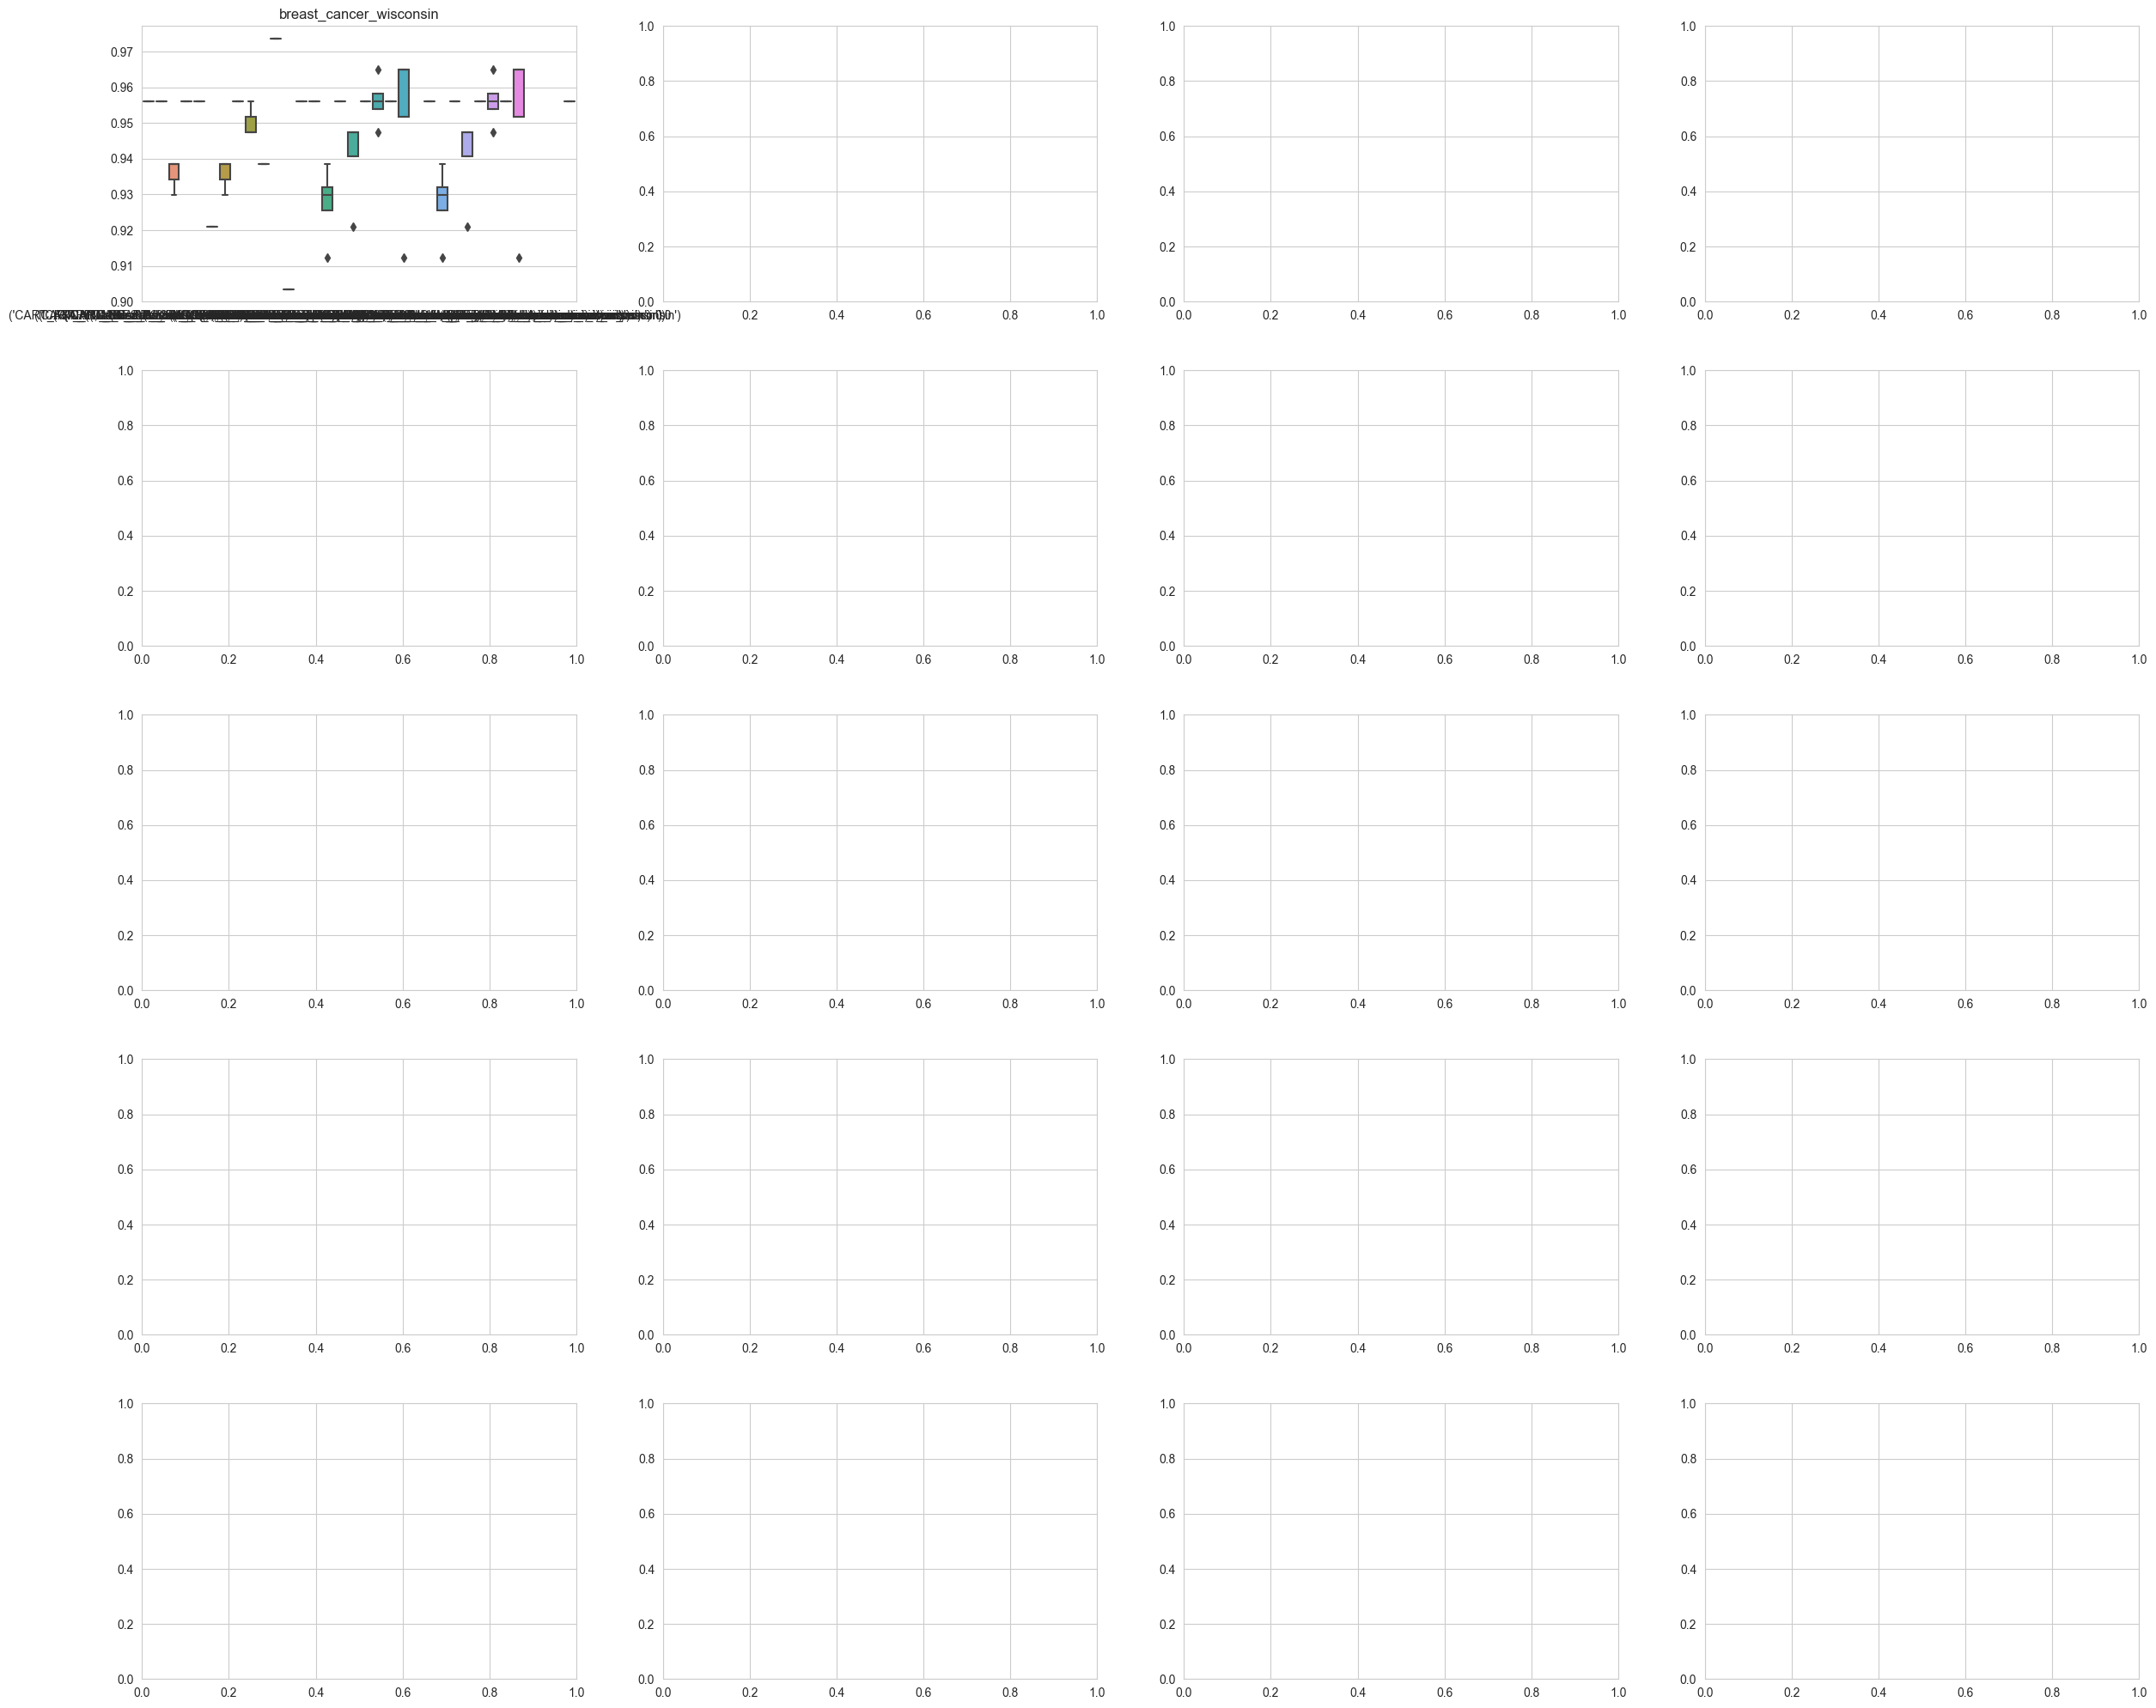

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 5, ncols = 4, gridspec_kw = {"hspace": 0.25})
import seaborn as sns
fig.set_size_inches(30, 25)
iteration = 0

for m in range(5):
    for j in range(4):

        dataset = classification_dataset_names[:20][iteration]

        columns = [i for i in k.columns if dataset in i]
        sns.boxplot(k[columns], ax = ax[m, j])

        ax[m, j].set_title(dataset)

        ax[m, j].set_xticklabels(['CART Rules', "OCT Rules", "Logistic Regression", "RuleFit", "ORRFA"])

        iteration += 1



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.boxplot(data = performance_by_iter)
fig.set_size_inches(20, 10)
ax.set_xticklabels(performance_by_iter.columns.values)
# ax.set_ylim(0.93, 0.995)
ax.tick_params(rotation = 0, labelsize = 14)
ax.set_ylabel("Accuracy", fontsize = 14)
ax.set_title("Accuracy of Logistic Regression, RuleFit and ORRFA", fontsize = 15)
# ax.set_ylabel()
plt.savefig('Benchmark ORRFA.png')

In [ ]:
iters=5
res_rul = {}
sc = StandardScaler()
names = ['Reg-CART','CART','ORT','OCT','ORT-H','OCT-H','ORT+ORT-H','OCT+OCT-H']

for classification_dataset in classification_dataset_names:
    df = fetch_data(classification_dataset)
    df, num_col, bin_col, cat_col = corr_data_for(df)
    if (df.shape[0] > 10000) | (df.shape[1] > 100) | (df.empty):
        continue
    y = df['target']
    X = df.loc[:, df.columns != 'target']

    print(color.BOLD + '\n\n    ----------------------------------------- {} -----------------------------------------'.format(classification_dataset) + color.END)
    rows_data, columns_data = X.shape
    print('Dataset Information')
    print('Rows:',rows_data,)
    print('Columns:',columns_data)
    print('Number of classes:',y.nunique())
    print('Continous columns:', len(num_col))
    print('Binary columns:', len(bin_col))
    print('Categorical columns:',len(cat_col))
    print('-------------------------------------------------')

    for it in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = it, stratify=y)
        X_col = X_train.columns
        col_len = len(X_col)
        X_test.name = "X_test"
        X_train.name = "X_train"
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        X_train = pd.DataFrame(X_train,columns=X_col)
        X_test = pd.DataFrame(X_test,columns=X_col)
        factors = ['all',0.5,1,1.2,1.4,1.6,1.8,2,2.5,3]

        models, performance = generate_tree(X_train, y_train, X_test, y_test, n_num=1, feat_size=len(X.columns),  max_iter_hy=2,sub_paths=True,depth_grid=range(1,7), depth_grid_hy=range(1,3), complexity_bi = 0.001, complexity_hy=0.001,  Reg_CART=False, ORT=False, ORT_H=False, Clas_CART=True, OCT=True, OCT_H=False)
        for perf,name in zip(performance,names):
            if not not perf:
                res_rul[(classification_dataset,name,it,1)] = sum(perf) / len(perf)

        act_name = []
        act_rules = []
        for model,name in zip(models,names):
            if (all(model)) & (not not model) & (None not in model):
                act_name.append(name)
                act_rules.append(model)

        datasets = gen_train_and_test_features(act_rules ,act_name , X_train, X_test)
        for model in datasets.keys():
            X_train_rules_and_features, X_test_rules_and_features = datasets[model][0]
            X_train_only_rules, X_test_only_rules = datasets[model][1]

            for len_c in factors:

                if len_c == 'all':
                    len_rule = 'all'
                    cols = SelectKBest(k='all').fit(X_train_rules_and_features,y_train).get_feature_names_out()
                    X_train_rules_features = X_train_rules_and_features[cols]
                    X_test_rules_features = X_test_rules_and_features[cols]

                    cols_1 = SelectKBest(k='all').fit(X_train_only_rules,y_train).get_feature_names_out()
                    X_train_rules = X_train_only_rules[cols_1]
                    X_test_rules = X_test_only_rules[cols_1]

                elif (round(col_len*len_c) <= X_train.shape[0]) & (round(col_len*len_c) <= len(X_train_rules_and_features.columns)):
                    min_feat_rule = round(col_len*len_c)
                    if (round(col_len*len_c) > len(X_train_only_rules.columns)) & (col_len != 0.5):
                        len_rule = 1
                        min_rule = len(X_train_only_rules.columns)
                    else:
                        len_rule = len_c
                        min_rule = min(round(col_len*len_c),len(X_train_only_rules.columns))


                    cols = SelectKBest(k=min_feat_rule).fit(X_train_rules_and_features,y_train).get_feature_names_out()
                    X_train_rules_features = X_train_rules_and_features[cols]
                    X_test_rules_features = X_test_rules_and_features[cols]

                    cols_1 = SelectKBest(k=min_rule).fit(X_train_only_rules,y_train).get_feature_names_out()
                    X_train_rules = X_train_only_rules[cols_1]
                    X_test_rules = X_test_only_rules[cols_1]

                else:
                     continue

                # Pipeline models
                only_rules_acc_LN = log_regression_pipeline(X_train_rules, X_test_rules, y_train, y_test)
                rules_and_features_acc_LN = log_regression_pipeline(X_train_rules_features, X_test_rules_features, y_train, y_test)
                res_rul[(classification_dataset,model + "_LG_rules",it,len_rule)] = only_rules_acc_LN
                res_rul[(classification_dataset,model + "_LG_rules_and_features",it,len_c)] = rules_and_features_acc_LN

                only_rules_acc_SVM = SVM_pipeline(X_train_rules, X_test_rules, y_train, y_test)
                rules_and_features_acc_SVM = SVM_pipeline(X_train_rules_features, X_test_rules_features, y_train, y_test)
                res_rul[(classification_dataset,model + "_SVM_rules",it,len_rule)] = only_rules_acc_SVM
                res_rul[(classification_dataset,model + "_SVM_rules_and_features",it,len_c)] = rules_and_features_acc_SVM

                only_rules_acc_NB = NB_pipeline(X_train_rules, X_test_rules, y_train, y_test)
                rules_and_features_acc_NB = NB_pipeline(X_train_rules_features, X_test_rules_features, y_train, y_test)
                res_rul[(classification_dataset,model + "_NB_rules",it,len_rule)] = only_rules_acc_NB
                res_rul[(classification_dataset,model + "_NB_rules_and_features",it,len_c)] = rules_and_features_acc_NB

                only_rules_acc_KNN = KNN_pipeline(X_train_rules, X_test_rules, y_train, y_test)
                rules_and_features_acc_KNN = KNN_pipeline(X_train_rules_features, X_test_rules_features, y_train, y_test)
                res_rul[(classification_dataset,model + "_KNN_rules",it,len_rule)] = only_rules_acc_KNN
                res_rul[(classification_dataset,model + "_KNN_rules_and_features",it,len_c)] = rules_and_features_acc_KNN


        res_rul[(classification_dataset,'Logistic_Regression',it,1)] = log_regression_pipeline(X_train, X_test, y_train, y_test)
        res_rul[(classification_dataset,"Support Vector Machine",it,1)] = SVM_pipeline(X_train, X_test, y_train, y_test)
        res_rul[(classification_dataset,"Naive Bayes",it,1)] = NB_pipeline(X_train, X_test, y_train, y_test)
        res_rul[(classification_dataset,"K-Nearest-Neighbor",it,1)] = KNN_pipeline(X_train, X_test, y_train, y_test)

In [ ]:
res_rul